jerk_raw    =  2400.0
jerk_shaped =  0.8810337137919737
ratio       =  2724.0728276678396


<Figure size 640x480 with 0 Axes>

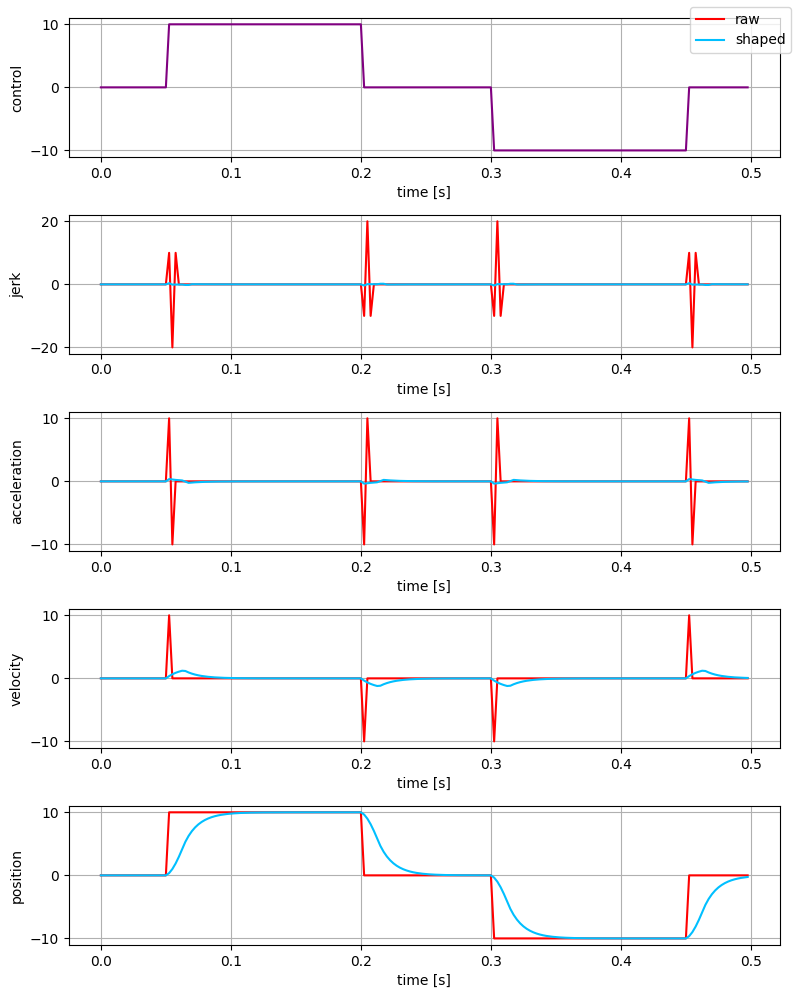

In [77]:
import LibsControl
import numpy
import matplotlib.pyplot as plt

#sampling frequency, 256Hz
dt       = 1.0/400.0


#process simulation
n_max = 200


'''
class Shaper:

    # alpha : system pole
    # order: fitler order
    def __init__(self, alpha, order = 4):
        self.order = order
        self.alpha = alpha
        self.x = numpy.zeros(order)


    def step(self, x_req):
        for i in range(self.order):
            if i == 0:
                x_in = x_req
            else:
                x_in = self.x[i-1]
            
            self.x[i] = self.alpha*self.x[i] + (1.0 - self.alpha)*x_in

        return self.x[-1]
'''


class ShaperA:

    #alpha : maximum aloved change per step
    def __init__(self, alpha):
        self.alpha  = alpha
        self.x_curr = 0.0

    def step(self, x_req):
        dif = x_req - self.x_curr 

        if numpy.abs(dif) > self.alpha:
            self.x_curr+= self.alpha*numpy.sign(dif)
        else:
            self.x_curr = x_req

        return self.x_curr 
    


class ShaperB:

    # ramp : maximum alloved change per step
    # alpha  : (0.0, 1.0), S-shape coeff
    # closer to 1 more S-like curve, 0 the shaper equals to trapezoidal
    def __init__(self, ramp, alpha = 0.5):
        self.ramp   = ramp
        self.alpha   = 1.0 - alpha

        self.x0 = 0.0
        self.x1 = 0.0

    def step(self, x_req):
        dif = x_req - self.x0 

        if numpy.abs(dif) > self.ramp:
            self.x0+= self.ramp*numpy.sign(dif)
        else:
            self.x0 = x_req

        self.x1 = (1.0 - self.alpha)*self.x1 + self.alpha*self.x0

        return self.x1



    
def comput_dif(x0, x1, x2, x3):
    vel  = x0 - x1
    acc  = x0 - 2.0*x1 + x2
    jerk = x0 - 3.0*x1 + 3.0*x2 - x3

    return vel, acc, jerk



def process_response(n_max, u_max = 1.0, shaper = None):
    #result log
    t_result = []
    
    u_result = []

    jerk_result = []
    acc_result = []
    vel_result = []
    x_result = []

    x0 = 0.0
    x1 = 0.0
    x2 = 0.0
    x3 = 0.0
    
    u = 0.0

    for n in range(n_max):

        #control input
        if n > 0.9*n_max:
            u = 0.0
        elif n > 0.6*n_max:
            u = -u_max
        elif n > 0.4*n_max:
            u = 0.0
        elif n > 0.1*n_max:  
            u = u_max
        else:
            u = 0.0

        x3 = x2
        x2 = x1
        x1 = x0

        if shaper is not None:
            x0 = shaper.step(u)
        else:
            x0 = u

        vel, acc, jerk = comput_dif(x0, x1, x2, x3)

    
        t_result.append(n*dt)
        u_result.append(u)

        jerk_result.append(jerk)
        acc_result.append(acc)
        vel_result.append(vel)
        x_result.append(x0)

        
        
    t_result = numpy.array(t_result)
    u_result = numpy.array(u_result)
    jerk_result = numpy.array(jerk_result)
    acc_result = numpy.array(acc_result)
    vel_result = numpy.array(vel_result)
    x_result = numpy.array(x_result)


    return t_result, u_result, jerk_result, acc_result, vel_result, x_result


#shaper = Shaper(0.5, 8)
shaper = ShaperB(1.8, 0.8)

u_max = 10.0

t_result_raw, u_result_raw, jerk_result_raw, acc_result_raw, vel_result, x_result_raw = process_response(n_max, u_max)
t_result_shaped, u_result_shaped, jerk_result_shaped, acc_result_shaped, vel_result_shaped, x_result_shaped = process_response(n_max, u_max, shaper)


plt.clf()

fig, axs = plt.subplots(5, 1, figsize=(8, 2*5))


axs[0].plot(t_result_raw, u_result_raw, color="purple")
axs[0].set_xlabel("time [s]")
axs[0].set_ylabel("control")
axs[0].grid()


axs[1].plot(t_result_raw, jerk_result_raw, label="raw", color="red")
axs[1].plot(t_result_raw, jerk_result_shaped, label="shaped", color="deepskyblue")
axs[1].set_xlabel("time [s]")
axs[1].set_ylabel("jerk") 
axs[1].grid()

axs[2].plot(t_result_raw, acc_result_raw, color="red")
axs[2].plot(t_result_raw, acc_result_shaped, color="deepskyblue")
axs[2].set_xlabel("time [s]")
axs[2].set_ylabel("acceleration")
axs[2].grid()

axs[3].plot(t_result_raw, vel_result, color="red")
axs[3].plot(t_result_raw, vel_result_shaped, color="deepskyblue")
axs[3].set_xlabel("time [s]")
axs[3].set_ylabel("velocity")
axs[3].grid()

axs[4].plot(t_result_raw, x_result_raw, color="red")
axs[4].plot(t_result_raw, x_result_shaped, color="deepskyblue")
axs[4].set_xlabel("time [s]")
axs[4].set_ylabel("position")
axs[4].grid()

fig.legend()

plt.tight_layout()

plt.tight_layout()
plt.savefig("shaper_result.png", dpi = 300)


jerk_raw = (jerk_result_raw**2).sum()
jerk_shaped = (jerk_result_shaped**2).sum()

print("jerk_raw    = ", jerk_raw)
print("jerk_shaped = ", jerk_shaped)
print("ratio       = ", jerk_raw/jerk_shaped)
